# Generating graphs of E vs. t, B vs. t, V vs. t, dBdt vs. t and ΔdBdt vs. t

# M = 10^2, D* = 10^(-6), P0 = 1

## Program Setup

In [1]:
# Import programs

import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import math

In [2]:
# Initialize constants for plots
num_bins = 200

axis_font = {'size':'40'}
title_font = {'size':'40'}

In [3]:
# Physical parameters
meandeltaT = np.pi
J = 300
dTau = 2 * np.pi / J
M = 10 ** 2
K = 1
N0 = 1
P0 = 1
Dstar = 10 ** (-6)
eps = 0.1
std = 0.01
eqmean = 0
Tr = K * meandeltaT

In [4]:
# Initial conditions
initial_B = 0
initial_u = 0

## Functions

In [5]:
# function that generates an array of values of DeltaT, time b/t collisions
def fundeltaT(num_bins, M, dTau):
    deltaT = []
    
    rayleigh = np.random.rayleigh(meandeltaT, M)
    hist, bin_edges = np.histogram(rayleigh, bins = num_bins, density = True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    
    for i in range(M):
        r = np.random.rand(1)
        deltaTtemp = inv_cdf(r)

        if (deltaTtemp % dTau < 0.005):
            deltaTtemp2 = deltaTtemp - (deltaTtemp % dTau)
        else:
            deltaTtemp2 = deltaTtemp + dTau - (deltaTtemp % dTau)
        deltaT.append(deltaTtemp2)
    
    return deltaT

In [6]:
# Generating an array of values of V
def funV(std, deltaT, eqmean, Tr):
    V = []
    y1 = 0
    
    for i in range(len(deltaT) - 1):
        Tn = (deltaT[i] + deltaT[i + 1]/2)
        
        stdevt = ((1 - math.exp(-2 * Tn/Tr)) * std ** 2) ** (1/2)
        meant = eqmean + math.exp(-Tn / Tr) * (y1 - eqmean)
        
        y1 = np.random.normal(meant, stdevt, 2)[0]
        V.append(y1)
        
    return V

In [7]:
# ***this function is not used in other versions of this program
# saving for potential future reference
# generating array of values of B, dB/dT, E, and delta dB/dt
def funB_dBdt_E_deltadBdt(Dstar, dTau, B, N0, P0, deltaT, M, eps, V, u):
    # created using Heun's method of integration 
    
    dBdt = [u]
    delta_dBdt = []
    Amp = [B]
    t = 0.0
    amptime = [t]
    E = []
    
    #nested loops for every collision and subsequently each value of deltaT   
    for i in range(0, M - 1):
        
        for j in range(0, int(deltaT[i]/dTau)):
            m1 = u
            k1 = - (Dstar * u) - B  - (N0 * B**2) - (P0 * B**3)
            m2 = u + dTau * k1
            B_2 = B + dTau * m1
            u_2 = m2
            k2 = - Dstar * u_2 - B_2 - (N0 * B_2**2) - (P0 * B_2**3)
            m2 = u + dTau * k2
            t = t + dTau
            B += (dTau / 2) * (m1 + m2)
            u += (dTau / 2) * (k1 + k2)
            
            # include? needed in outer loop?
            if math.isnan(B) or abs(B) > 1:
                break
                
            Amp.append(B)
            amptime.append(t)
            E.append((1/2 * u**2) + (1/2 * B**2) + (1/3 * N0 * B**3) + (1/4 * P0 * B**4))
            
        # Equation 9
        # Returns dBdt from previous collision
        V_i = V[i]
        dbdtf = u
        u = dbdtf + 2 * eps * (V_i - dbdtf)
        dBdt.append(u)   
        
        if i != 0:
                delta_dBdt.append(dBdt[i] - dBdt[i - 1])
            
    
    return Amp, amptime, E, dBdt, delta_dBdt

In [12]:
def funplots(amptime, E, Amp, V, dBdt, delta_dBdt):
    fig, axs = plt.subplots(5, 1, figsize=(40,40))
    fig.subplots_adjust(hspace=0) 
    
    axs[0].plot(amptime[:98], delta_dBdt, 'k')
    axs[0].set_ylabel('\u0394dBdt', **axis_font)
    axs[0].set_xlabel('T', **axis_font)
    axs[0].tick_params(axis = 'both', labelsize = 20)
    
    axs[1].plot(amptime[:100], dBdt, '.k')
    axs[1].set_ylabel('dBdt', **axis_font)
    axs[1].set_xlabel('T', **axis_font)
    axs[1].tick_params(axis = 'both', labelsize = 20)
    
    axs[2].plot(amptime[:99], V, '.k')
    axs[2].set_ylabel('V', **axis_font)
    axs[2].set_xlabel('T', **axis_font)
    axs[2].tick_params(axis = 'both', labelsize = 20)
    
    axs[3].plot(amptime, Amp, 'k')
    axs[3].set_ylabel('B', **axis_font)
    axs[3].set_xlabel('T', **axis_font)
    axs[3].tick_params(axis = 'both', labelsize = 20)
    
    axs[4].plot(amptime[:-1], E, 'k')
    axs[4].set_ylabel('E', **axis_font)
    axs[4].set_xlabel('T', **axis_font)
    axs[4].tick_params(axis = 'both', labelsize = 20)
    
    plt.show()


## Generating Graphs

In [13]:
# running functions for sample plot  
deltaT = fundeltaT(num_bins, M, dTau)
V = funV(std, deltaT, eqmean, Tr)
Amp, amptime, E, dBdt, delta_dBdt = funB_dBdt_E_deltadBdt(Dstar, dTau, initial_B, N0, P0, deltaT, M, eps, V, initial_u)

In [14]:
print(len(amptime))
print(len(V))
print(len(Amp))
print(len(E))
print(len(dBdt))
print(len(delta_dBdt))

20098
99
20098
20097
100
98


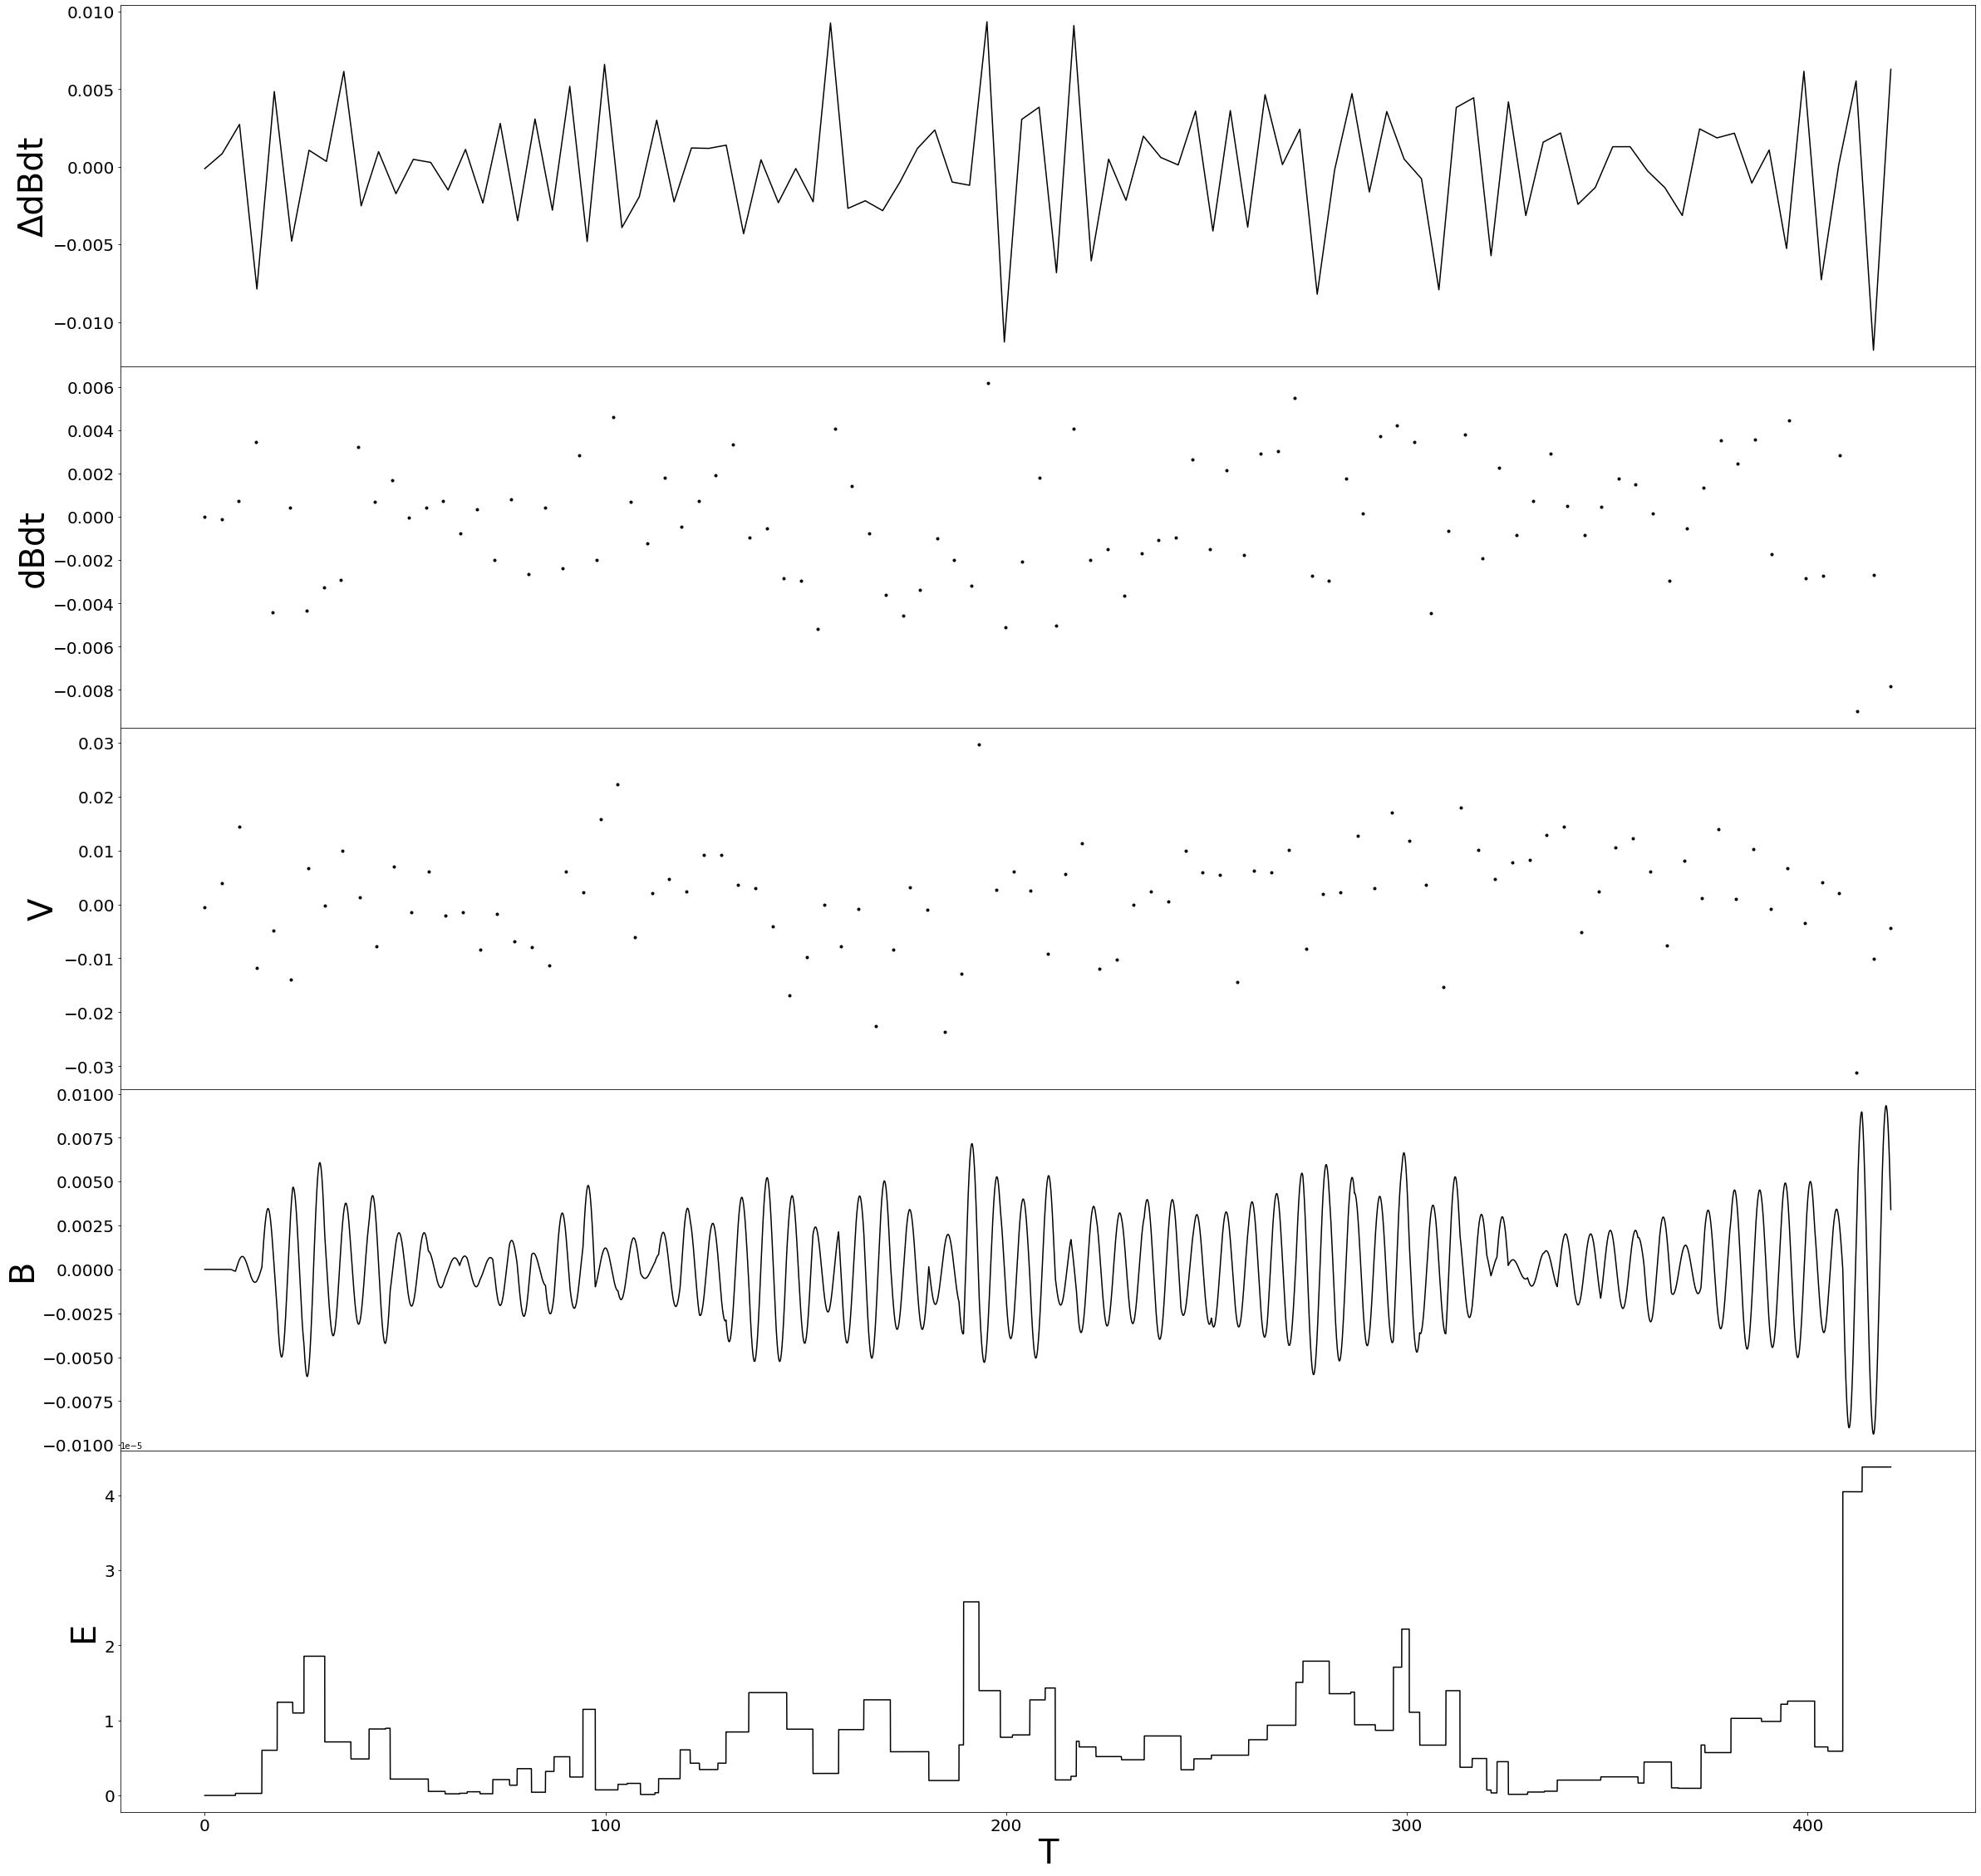

In [15]:
funplots(amptime, E, Amp, V, dBdt, delta_dBdt)